### IMPORTS AND SETUP

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.wkt
import os, warnings
warnings.filterwarnings("ignore", category=UserWarning)

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
import rioxarray as rxr
import rasterio
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.base import clone
from sklearn.cluster import DBSCAN
from joblib import dump
from shapely import wkt
import matplotlib.pyplot as plt

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
SHOW_PLOTS = True

### FEATURE TOGGLES

In [2]:
FEATURE_FLAGS = {
    # building coverage
    "building_cov_100m": True,
    "building_cov_200m": True,
    "building_cov_500m": True,

    # parks coverage
    "park_cov_1000m": True,

    # new: water coverage
    "water_cov_1000m": True,

    # new: street trees coverage => we can do a "point->buffer" approach
    "street_tree_cov_500m": True,

    # distance to city center
    "dist_to_closest_calculated_city_centroid": True,

    # mathematically calculated neighbourhood clustering
    "location_cluster": True,

    # official cluster approach (point-in-polygon with official NTA or neighborhoods)
    "official_cluster": False,

    # census data for population density
    "population_density": False,

    # subway stations data
    "dist_to_closest_subway_station": True,

    # raster-based features
    "lst_value": True,
    "ndvi_value": True,
    "ndbi_value": True,
    "ndwi_value": True,
    "evi_value": False
}

### HELPER FUNCTIONS

In [3]:
def coverage_fraction(geom, polygon_gdf, radius=50):
    """
    coverage_fraction:
      - We do buffer around 'geom' by 'radius'.
      - Clip polygon_gdf with that buffer.
      - Sum area of clipped polygons / area of buffer => coverage fraction.
    """
    buffer_poly = geom.buffer(radius)
    clipped = gpd.clip(polygon_gdf, buffer_poly)
    area_polygons = clipped.geometry.area.sum()
    area_buffer = buffer_poly.area
    return area_polygons / area_buffer if area_buffer > 0 else 0

# def building_coverage_fraction(geom, building_gdf, radius=50):
#     buffer_poly = geom.buffer(radius)
#     clipped = gpd.clip(building_gdf, buffer_poly)
#     area_buildings = clipped.geometry.area.sum()
#     area_buf = buffer_poly.area
#     return area_buildings / area_buf if area_buf > 0 else 0

def distance_to_polygons(geom, poly_gdf):
    dists = poly_gdf.geometry.distance(geom)
    return dists.min() if len(dists)>0 else np.nan

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def extract_raster_value(geom, raster, band_index=1, method="nearest"):
    """Return the pixel value from raster at geom's location."""
    x, y = geom.x, geom.y
    val = raster.sel(x=x, y=y, band=band_index, method=method).values
    return float(val)

def point_in_official_cluster(geom, cluster_gdf, id_column="NTACode"):
    """
    If official_cluster is True, we do a point-in-polygon sjoin
    with an official neighborhoods or NTA shapefile that has an 'id_column'
    representing the area ID.
    """
    pt_gdf = gpd.GeoDataFrame([1], geometry=[geom], crs=cluster_gdf.crs)
    joined = gpd.sjoin(pt_gdf, cluster_gdf, how="left", predicate="within")
    if len(joined)==0:
        return -1
    else:
        return joined[id_column].iloc[0]  # or name field

def compute_evi(blue, red, nir, L=1.0, C1=6.0, C2=7.5, G=2.5):
    return G * (nir - red) / (nir + C1*red - C2*blue + L)

### LOAD BOROUGH BOUNDARIES, BUILDINGS, WATER, PARKS, TREES

In [4]:
print("Loading building footprints, parks, water coverage, street tree CSV...")

# 3.0 NYC boroughs
# gdf_boroughs = gpd.read_file("./data/nyc_boroughs.geojson").to_crs("EPSG:2263")
# if "name" in gdf_boroughs.columns:
#     gdf_boroughs.rename(columns={"name":"BoroName"}, inplace=True)

# 3.1 Building footprints
gdf_buildings = gpd.read_file("./data/Building_Footprint_1GB.kml").to_crs("EPSG:2263")
# gdf_buildings = gpd.sjoin(gdf_buildings, gdf_boroughs, how="left", predicate="intersects")
# gdf_buildings = gdf_buildings.dropna(subset=["BoroName"])

# 3.2 Parks
gdf_parks = gpd.read_file("./data/Parks_Properties_20250123.kml").to_crs("EPSG:2263")

# 3.3 Water
gdf_water = pd.read_csv("./data/NYC_Planimetric_Database__Hydrography_20250123.csv")
gdf_water["geometry"] = gdf_water["the_geom"].apply(wkt.loads)
gdf_water = gpd.GeoDataFrame(gdf_water, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:2263")

# 3.4 Street Trees from 2015 Census (CSV with lat/lon)
df_trees = pd.read_csv("./data/2015_Street_Tree_Census_-_Tree_Data_20250205.csv")
# columns: [tree_id, block_id, created_at, tree_dbh, lat, lon, ...] => check real col names
# Actually from your snippet: "latitude","longitude"
df_trees.rename(columns={"latitude":"lat","longitude":"lon"}, inplace=True)
# convert to geodf in EPSG:2263
gdf_trees_pts = gpd.GeoDataFrame(
    df_trees,
    geometry=[Point(lon, lat) for lon, lat in zip(df_trees["lon"], df_trees["lat"])],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

# We can create a small buffer around each tree => approximate canopy => polygons:
# Maybe scale buffer by DBH? For simplicity, do 2m buffer:
gdf_trees_poly = gdf_trees_pts.copy()
gdf_trees_poly["geometry"] = gdf_trees_poly.geometry.buffer(2.0)  # 2m radius
    
# 3.6 Official Cluster Polygons (NTAs or Neighborhoods)
# gdf_official_clusters = gpd.read_file("./data/2020_NTAs.shp").to_crs("EPSG:2263")

# 3.7 Population Census for population density
# gdf_census = gpd.read_file("./data/2020 Census Tracts_20250206.geojson").to_crs("EPSG:2263")

# 3.8 Subway stations
gdf_stations = gpd.read_file("./data/MTA Subway Stations_20250206.geojson").to_crs("EPSG:2263")

print("Done")

Loading building footprints, parks, water coverage, street tree CSV...
Done


In [6]:
# Load training data
df_train = pd.read_csv("./data/Training_data_uhi_index_UHI2025-v2.csv")
gdf_train = gpd.GeoDataFrame(
    df_train,
    geometry=[Point(lon, lat) for lon, lat in zip(df_train.Longitude, df_train.Latitude)],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

In [7]:
import geopandas as gpd
from shapely.geometry import box

# 1. Extract the total bounds of gdf_train
minx_train, miny_train, maxx_train, maxy_train = gdf_train.total_bounds

# 2. Define a buffer in the same units as your CRS (here, meters)
buffer = 1000  # adjust this value if you need a slightly larger or smaller margin

# 3. Create an expanded bounding box
expanded_bbox = box(minx_train - buffer, 
                    miny_train - buffer, 
                    maxx_train + buffer, 
                    maxy_train + buffer)

# Optional: If you want to see the coordinates of the expanded bounding box:
print("Expanded Bounding Box:", expanded_bbox.bounds)

# 4. Create a sub-dataframe from gdf_buildings 1GB that only contains features intersecting the expanded bbox
gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(expanded_bbox)]
gdf_buildings['centroid'] = gdf_buildings.geometry.centroid

# Check the total bounds of the new subset
print("Subset Total Bounds:", gdf_buildings.total_bounds)
print("Train Total Bounds:", gdf_train.total_bounds)

Expanded Bounding Box: (984785.411382811, 214727.52933294218, 1018620.8402454641, 253422.67726362712)
Subset Total Bounds: [ 984092.05017281  214355.31379316 1019093.78397498  253922.21989541]
Train Total Bounds: [ 985785.41138281  215727.52933294 1017620.84024546  252422.67726363]


Centroid of the largest cluster of buildings in the city x/y: 996064.2417689428, 228804.5354336919


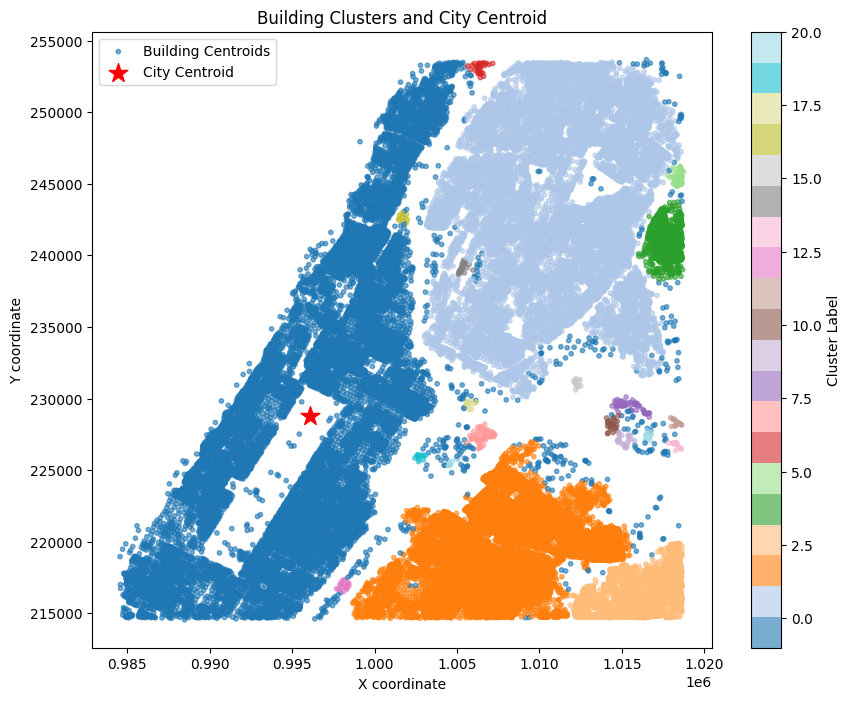

In [8]:
# Find the centroid of the largest cluster of building points.
coords = np.column_stack([gdf_buildings.centroid.x, gdf_buildings.centroid.y]) # Extract coordinates from centroids

# Cluster building points using DBSCAN
# These parameters are chosen to merge clusters (e.g., Manhattan and Bronx) in NYC.
eps_m = 400   # maximum distance (in meters) to consider two points as neighbors
min_samples = 10  # minimum number of points required to form a cluster
db = DBSCAN(eps=eps_m, min_samples=min_samples).fit(coords)
labels = db.labels_
gdf_buildings['cluster'] = labels

# Determine the largest cluster (ignoring noise, which is labeled -1)
valid_mask = (labels >= 0)
if np.any(valid_mask):
    unique_labels, counts = np.unique(labels[valid_mask], return_counts=True)
    largest_label = unique_labels[np.argmax(counts)]
    in_largest = coords[labels == largest_label]
    if len(in_largest) > 0:
        city_centroid = MultiPoint(in_largest).centroid
    else:
        city_centroid = MultiPoint(coords).centroid
else:
    city_centroid = MultiPoint(coords).centroid

city_x, city_y = city_centroid.x, city_centroid.y
print(f"Centroid of the largest cluster of buildings in the city x/y: {city_x}, {city_y}")

if SHOW_PLOTS:
    # Plot all building centroids colored by their cluster labels, and overlay the city centroid
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot: Use a colormap (e.g., 'tab20') to distinguish different clusters.
    # Noise points (label -1) will get their own color.
    scatter = ax.scatter(
        coords[:, 0], 
        coords[:, 1], 
        c=labels, 
        cmap='tab20', 
        s=10, 
        alpha=0.6,
        label="Building Centroids"
    )
    
    # Overlay the city centroid as a large red star
    ax.scatter(city_centroid.x, city_centroid.y, color='red', marker='*', s=200, label='City Centroid')
    
    ax.set_title("Building Clusters and City Centroid")
    ax.set_xlabel("X coordinate")
    ax.set_ylabel("Y coordinate")
    ax.legend()
    plt.colorbar(scatter, ax=ax, label="Cluster Label")
    plt.show()

### LOAD + CHECK RASTERS

In [9]:
print("Loading reprojected LST + Indices...")
lst_raster = rxr.open_rasterio("Landsat_LST_v4_single_0601_0901.tiff")
lst_raster_2263 = lst_raster.rio.reproject("EPSG:2263")

indices_raster = rxr.open_rasterio("S2_indices_v4_single_0601_0901.tiff")
indices_raster_2263 = indices_raster.rio.reproject("EPSG:2263")

# Check if the rasters actually have valid data
ratio_lst = (~lst_raster_2263.isnull()).mean().values
ratio_idx = (~indices_raster_2263.isnull()).mean().values
print(f"LST valid ratio: {ratio_lst:.3f}")
print(f"Indices valid ratio: {ratio_idx:.3f}")

if ratio_lst == 0.0:
    print("WARNING: LST raster is entirely NaN. Possibly an empty mosaic or over-strict cloud mask!")
if ratio_idx == 0.0:
    print("WARNING: Indices raster is entirely NaN. Possibly an empty mosaic or over-strict cloud mask!")

print("LST raster bounds:", lst_raster_2263.rio.bounds())
print("Indices raster bounds:", indices_raster_2263.rio.bounds())

Loading reprojected LST + Indices...
LST valid ratio: 1.000
Indices valid ratio: 0.998
LST raster bounds: (981437.4489166049, 212457.54099916507, 1023088.2146540903, 260009.54459268012)
Indices raster bounds: (981462.3462672028, 212512.28574393364, 1023050.6163433938, 259944.0070645518)


### BUILD TRAINING FEATURES

In [10]:
# Prepare empty arrays for each feature
arr_cov_bld_100  = []
arr_cov_bld_200  = []
arr_cov_bld_500  = []

arr_cov_park_1000 = []
arr_cov_tree_500  = []
arr_cov_water_1000 = []

arr_dist_city_centroid = []
arr_dist_subway_station = []

arr_lst_vals  = []
arr_ndvi_vals = []
arr_ndbi_vals = []
arr_ndwi_vals = []

# If you eventually compute location_cluster, official_cluster, population_density,
# you'd prepare arrays for them as well. For now we skip them or store 0.

total_rows = len(gdf_train)
print(f"total rows: {total_rows}")

for i, row in gdf_train.iterrows():
    if i % 1000 == 0:
        percent_done = (i / total_rows) * 100
        print(f"{percent_done:.2f}%")
        
    geom = row.geometry
    
    # building coverage
    if FEATURE_FLAGS["building_cov_100m"]:
        b100 = coverage_fraction(geom, gdf_buildings, 100)
    else:
        b100 = 0
    arr_cov_bld_100.append(b100)

    if FEATURE_FLAGS["building_cov_200m"]:
        b200 = coverage_fraction(geom, gdf_buildings, 200)
    else:
        b200 = 0
    arr_cov_bld_200.append(b200)

    if FEATURE_FLAGS["building_cov_500m"]:
        b500 = coverage_fraction(geom, gdf_buildings, 500)
    else:
        b500 = 0
    arr_cov_bld_500.append(b500)

    # park coverage
    if FEATURE_FLAGS["park_cov_1000m"]:
        p1000 = coverage_fraction(geom, gdf_parks, 1000)
    else:
        p1000 = 0
    arr_cov_park_1000.append(p1000)

    # street trees coverage
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        t500 = coverage_fraction(geom, gdf_trees_poly, 500)
    else:
        t500 = 0
    arr_cov_tree_500.append(t500)

    # water coverage
    if FEATURE_FLAGS["water_cov_1000m"]:
        w1000 = coverage_fraction(geom, gdf_water, 1000)
    else:
        w1000 = 0
    arr_cov_water_1000.append(w1000)

    # distance to city centroid (calculated)
    if FEATURE_FLAGS["dist_to_closest_calculated_city_centroid"]:
        d_centroid = euclidean_distance(geom.x, geom.y, city_x, city_y)
    else:
        d_centroid = None
    arr_dist_city_centroid.append(d_centroid)

    # distance to nearest subway station
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists = gdf_stations.geometry.distance(geom)
        dist_min = dists.min() if len(dists) > 0 else 0
    else:
        dist_min = None
    arr_dist_subway_station.append(dist_min)

    # LST / NDVI / NDBI / NDWI
    if FEATURE_FLAGS["lst_value"]:
        lv = extract_raster_value(geom, lst_raster_2263, band_index=1)
    else:
        lv = 0
    arr_lst_vals.append(lv)

    if FEATURE_FLAGS["ndvi_value"]:
        ndv = extract_raster_value(geom, indices_raster_2263, band_index=1)
    else:
        ndv = 0
    arr_ndvi_vals.append(ndv)

    if FEATURE_FLAGS["ndbi_value"]:
        ndb = extract_raster_value(geom, indices_raster_2263, band_index=2)
    else:
        ndb = 0
    arr_ndbi_vals.append(ndb)

    if FEATURE_FLAGS["ndwi_value"]:
        ndw = extract_raster_value(geom, indices_raster_2263, band_index=3)
    else:
        ndw = 0
    arr_ndwi_vals.append(ndw)

print("100.00% Done with feature computations.")

# Attach columns to gdf_train if the flag is True
if FEATURE_FLAGS["building_cov_100m"]:
    gdf_train["building_cov_100m"] = arr_cov_bld_100

if FEATURE_FLAGS["building_cov_200m"]:
    gdf_train["building_cov_200m"] = arr_cov_bld_200

if FEATURE_FLAGS["building_cov_500m"]:
    gdf_train["building_cov_500m"] = arr_cov_bld_500

if FEATURE_FLAGS["park_cov_1000m"]:
    gdf_train["park_cov_1000m"] = arr_cov_park_1000

if FEATURE_FLAGS["street_tree_cov_500m"]:
    gdf_train["street_tree_cov_500m"] = arr_cov_tree_500

if FEATURE_FLAGS["water_cov_1000m"]:
    gdf_train["water_cov_1000m"] = arr_cov_water_1000

if FEATURE_FLAGS["dist_to_closest_calculated_city_centroid"]:
    gdf_train["dist_to_closest_calculated_city_centroid"] = arr_dist_city_centroid

if FEATURE_FLAGS["dist_to_closest_subway_station"]:
    gdf_train["dist_to_closest_subway_station"] = arr_dist_subway_station

if FEATURE_FLAGS["lst_value"]:
    gdf_train["lst_value"] = arr_lst_vals

if FEATURE_FLAGS["ndvi_value"]:
    gdf_train["ndvi_value"] = arr_ndvi_vals

if FEATURE_FLAGS["ndbi_value"]:
    gdf_train["ndbi_value"] = arr_ndbi_vals

if FEATURE_FLAGS["ndwi_value"]:
    gdf_train["ndwi_value"] = arr_ndwi_vals

# optional KMeans
if FEATURE_FLAGS["location_cluster"]:
    from sklearn.cluster import KMeans
    N_CLUSTERS = 10
    coords_train = np.column_stack([gdf_train.geometry.x, gdf_train.geometry.y])
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_SEED, n_init=10).fit(coords_train)
    gdf_train["location_cluster"] = kmeans.labels_

print("Done attaching columns.")

total rows: 11229
0.00%
8.91%
17.81%
26.72%
35.62%
44.53%
53.43%
62.34%
71.24%
80.15%
89.06%
97.96%
100.00% Done with feature computations.
Done attaching columns.


### OUTLIER REMOVAL

In [11]:
# E.g. cap y above 99th percentile
cap_quantile= 0.99
cap_val= gdf_train["UHI Index"].quantile(cap_quantile)
mask_out= (gdf_train["UHI Index"]> cap_val)
if mask_out.sum()>0:
    print(f"Capping {mask_out.sum()} outliers above Q={cap_quantile} at {cap_val:.3f}")
    gdf_train.loc[mask_out, "UHI Index"]= cap_val

Capping 110 outliers above Q=0.99 at 1.037


### FINAL FEATURE TABLE

In [12]:
feature_cols = []

if FEATURE_FLAGS["building_cov_100m"]:
    feature_cols.append("building_cov_100m")
if FEATURE_FLAGS["building_cov_200m"]:
    feature_cols.append("building_cov_200m")
if FEATURE_FLAGS["building_cov_500m"]:
    feature_cols.append("building_cov_500m")

if FEATURE_FLAGS["park_cov_1000m"]:
    feature_cols.append("park_cov_1000m")

if FEATURE_FLAGS["street_tree_cov_500m"]:
    feature_cols.append("street_tree_cov_500m")

if FEATURE_FLAGS["water_cov_1000m"]:
    feature_cols.append("water_cov_1000m")

if FEATURE_FLAGS["dist_to_closest_calculated_city_centroid"]:
    feature_cols.append("dist_to_closest_calculated_city_centroid")

if FEATURE_FLAGS["dist_to_closest_subway_station"]:
    feature_cols.append("dist_to_closest_subway_station")

if FEATURE_FLAGS["lst_value"]:
    feature_cols.append("lst_value")

if FEATURE_FLAGS["ndvi_value"]:
    feature_cols.append("ndvi_value")

if FEATURE_FLAGS["ndbi_value"]:
    feature_cols.append("ndbi_value")

if FEATURE_FLAGS["ndwi_value"]:
    feature_cols.append("ndwi_value")

if FEATURE_FLAGS["location_cluster"]:
    feature_cols.append("location_cluster")
if FEATURE_FLAGS["official_cluster"]:
    feature_cols.append("official_cluster")
if FEATURE_FLAGS["population_density"]:
    feature_cols.append("population_density")

df_train_feat = gdf_train[feature_cols].fillna(0.0)
X = df_train_feat.values
y = gdf_train["UHI Index"].values

print("Train shape:", X.shape)
print("Feature columns:", feature_cols)

Train shape: (11229, 13)
Feature columns: ['building_cov_100m', 'building_cov_200m', 'building_cov_500m', 'park_cov_1000m', 'street_tree_cov_500m', 'water_cov_1000m', 'dist_to_closest_calculated_city_centroid', 'dist_to_closest_subway_station', 'lst_value', 'ndvi_value', 'ndbi_value', 'ndwi_value', 'location_cluster']


In [13]:
df_train_feat.describe()

,building_cov_100m,building_cov_200m,building_cov_500m,park_cov_1000m,street_tree_cov_500m,water_cov_1000m,dist_to_closest_calculated_city_centroid,dist_to_closest_subway_station,lst_value,ndvi_value,ndbi_value,ndwi_value,location_cluster
count,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000,11229.000000
mean,0.234999,0.302181,0.314795,0.134602,0.001550,0.027818,12450.963141,1346.473005,40.654181,-0.006387,-0.002206,0.023604,4.500579
std,0.163679,0.150436,0.119932,0.206115,0.000785,0.073319,6770.826898,909.205876,2.714054,0.062528,0.065959,0.047172,2.735151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,597.154359,7.600310,32.484185,-0.231795,-0.353383,-0.499395,0.000000
25%,0.103135,0.205055,0.251169,0.019679,0.001008,0.000000,6400.080023,735.246718,39.227938,-0.037236,-0.036320,0.015558,2.000000
50%,0.231493,0.319721,0.324589,0.049527,0.001570,0.000000,12048.633014,1125.301971,40.868588,-0.019680,-0.004430,0.032591,5.000000
75%,0.347422,0.407613,0.397363,0.150680,0.002091,0.003372,18456.224552,1725.086477,42.341754,0.006772,0.030177,0.045274,7.000000
max,0.975584,0.752957,0.646870,1.000000,0.003626,0.501981,25349.642864,6033.752229,54.564594,0.562697,0.440744,0.165486,9.000000


In [14]:
df_train_feat

,building_cov_100m,building_cov_200m,building_cov_500m,park_cov_1000m,street_tree_cov_500m,water_cov_1000m,dist_to_closest_calculated_city_centroid,dist_to_closest_subway_station,lst_value,ndvi_value,ndbi_value,ndwi_value,location_cluster
0,0.102016,0.224017,0.307180,0.204547,0.001072,0.000000,14928.533427,1288.844077,41.442815,-0.032849,-0.027607,0.044681,5
1,0.136744,0.231028,0.304410,0.210895,0.001084,0.000000,14913.501297,1311.950618,41.442815,-0.017685,-0.025670,0.039056,5
2,0.156528,0.247944,0.302863,0.218289,0.001075,0.000000,14895.612831,1337.471817,41.442815,-0.023479,-0.024851,0.039874,5
3,0.172050,0.277356,0.304253,0.225406,0.001026,0.000000,14877.616672,1364.019827,41.152283,-0.024157,-0.027820,0.041210,5
4,0.199851,0.316331,0.309865,0.230791,0.000978,0.000000,14863.620378,1387.305279,41.152283,-0.024157,-0.027820,0.041210,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,0.000000,0.000000,0.000000,0.901596,0.000000,0.057350,1586.917240,2170.218829,34.890471,0.028827,-0.023243,-0.000817,4
11225,0.000000,0.000000,0.000000,0.901045,0.000000,0.059504,1595.838375,2168.641060,34.890471,0.051500,-0.028651,-0.016411,4
11226,0.000000,0.000000,0.000000,0.901269,0.000000,0.063221,1609.425916,2163.730048,34.890471,0.051500,-0.028651,-0.016411,4
11227,0.000000,0.000000,0.000000,0.901956,0.000000,0.065068,1615.294583,2160.203993,34.890471,0.048808,-0.048659,-0.018743,4


### DEFINE STRATIFIED CV

In [15]:
def make_stratified_bins(target, n_bins=10):
    """Bin the continuous target into discrete intervals for use in 'StratifiedKFold'."""
    # pd.qcut => quantile-based discretization
    bins = pd.qcut(target, q=n_bins, duplicates="drop")  # If duplicates occur, drop them
    return bins.astype(str)  # Convert to string labels

K_FOLDS = 10

y_bins = make_stratified_bins(y, n_bins=10)
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
# kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [18]:
# Model definitions and parameter grids
models_and_params = {
    "KNeighbors": (
        KNeighborsRegressor(),
        {
            "n_neighbors": [2, 3, 4, 5, 7, 10],
            "weights": ["uniform", "distance"],
            "p": [1, 2, 3, 4],
            "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
            "leaf_size": [10, 20, 30, 40],
            "metric": ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
        }
    ),
    "LightGBM": (
        lgb.LGBMRegressor(random_state=RANDOM_SEED),
        {
            # "n_estimators": [200, 500, 700, 1000],
            "n_estimators": [100, 200, 400, 500],
            "max_depth": [-1, 10, 20, 40],
            "learning_rate": [0.05, 0.1, 0.15, 0.2],
            "subsample": [0.6, 0.8, 1.0],
            "colsample_bytree": [0.7, 0.8, 0.9],
            "boosting_type": ["gbdt", "dart", "rf"],
            "num_leaves": [15, 31, 63],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [1.0, 2.0, 0.5],
        }
    ),
    "CatBoost": (
        CatBoostRegressor(silent=True, random_state=RANDOM_SEED),
        {
            # "iterations": [200, 500, 700, 1000],
            "iterations": [100, 200, 400, 500],
            "max_depth": [5, 10, 15, 20],
            "learning_rate": [0.05, 0.1, 0.15, 0.2],
            "random_strength": [1, 2, 3, 5],
        }
    ),
    "HistGradientBoosting": (
        HistGradientBoostingRegressor(random_state=RANDOM_SEED),
        {
            # "max_iter": [200, 500, 700, 1000],
            "max_iter": [100, 200, 400, 500],
            "learning_rate": [0.001, 0.01, 0.05, 0.1],
            "max_depth": [None, 10, 20, 40],
            "max_leaf_nodes": [15, 31, 63],
            "l2_regularization": [0.0, 0.1, 1.0],
            "loss": ["squared_error", "absolute_error", "gamma", "poisson", "quantile"],
            "quantile": [0.1, 0.5, 0.9],
            "min_samples_leaf": [10, 20, 40],
            "warm_start": [True, False],
        }
    ),
    "DecisionTree": (
        DecisionTreeRegressor(random_state=RANDOM_SEED),
        {
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "splitter": ["best", "random"],
            "max_depth": [None, 10, 20, 40],
            "min_samples_leaf": [1, 2, 3],
        }
    ),
    "RandomForest": (
        RandomForestRegressor(random_state=RANDOM_SEED),
        {
            # "n_estimators": [200, 500, 700, 1000],
            "n_estimators": [100, 200, 400, 500],
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "max_depth": [None, 10, 20, 40],
            "min_samples_leaf": [1, 2, 3],
            "min_samples_split": [2, 4, 8],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            "bootstrap": [False, True],
            "oob_score": [False, True],   # only valid if bootstrap=True
        }
    ),
    "ExtraTrees":(
        ExtraTreesRegressor(random_state=RANDOM_SEED),
        {
            # "n_estimators": [200, 500, 1000, 2000],
            "n_estimators": [100, 200, 400, 500],
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "max_depth": [None, 10, 20, 40],
            "min_samples_split": [2, 4, 8],
            "min_samples_leaf": [1, 2, 5],
            "max_features": [1.0, "sqrt", "log2", 0.5],
            "ccp_alpha": [0.0, 0.001, 0.01],
            "bootstrap": [False, True],
            "oob_score": [False, True],   # only valid if bootstrap=True
        }
    ),
    "XGBoost":(
        xgb.XGBRegressor(random_state=RANDOM_SEED, use_label_encoder=False, eval_metric="rmse"),
        {
            # "n_estimators": [500, 1000, 1500, 2000],
            "n_estimators": [100, 200, 400, 500],
            "learning_rate": [0.005, 0.01, 0.05],
            "max_depth": [5, 10, 15, 20, 25],
            "booster": ["gbtree", "dart"],
            "gamma": [0, 0.1, 1],
            "reg_alpha": [0, 0.1, 1],
            "reg_lambda": [0.5, 1.0, 2.0, 5.0],
            "subsample": [0.6, 0.7, 0.8, 0.9],
            "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
            "tree_method": ["auto", "hist", "approx"],
        }
    ),
}

In [ ]:
N_ITER = 30
results = []

for model_name, (model, param_grid) in models_and_params.items():
    print(f"\n=== Searching {model_name} ===")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=N_ITER,
        cv=list(skf.split(X, y_bins)),
        scoring="r2",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X, y)
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_

    results.append({
        "Model": model_name,
        "Best Estimator": best_estimator,
        "Best Score (CV)": best_score,
        "Best Params": best_params
    })

results_df = pd.DataFrame(results).sort_values(by="Best Score (CV)", ascending=False)
print("\nFinal Cross-Val Results:\n", results_df)


=== Searching KNeighbors ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits

=== Searching LightGBM ===
Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
results_df.to_csv('results_df.csv', index=False, sep='|')
results_df

### VALIDATION DATA

In [ ]:
df_val = pd.read_csv("./data/Submission_template_UHI2025-v2.csv")
gdf_val = gpd.GeoDataFrame(
    df_val,
    geometry=[Point(lon, lat) for lon, lat in zip(df_val.Longitude, df_val.Latitude)],
    crs="EPSG:4326"
).to_crs("EPSG:2263")

# We'll create a dictionary to hold computed values for each feature flag
computed_feature_values = {key: [] for key in FEATURE_FLAGS if FEATURE_FLAGS[key]}

total_rows = len(gdf_val)
print(f"total rows: {total_rows}")

for idx, row in gdf_val.iterrows():
    if idx % 100 == 0:
        percent_done = (idx / total_rows) * 100
        print(f"{percent_done:.2f}%")
    
    geom = row.geometry
    
    # 1) building_cov_100m
    if FEATURE_FLAGS["building_cov_100m"]:
        val_bld_100 = coverage_fraction(geom, gdf_buildings, 100)
        computed_feature_values["building_cov_100m"].append(val_bld_100)
    
    # 2) building_cov_200m
    if FEATURE_FLAGS["building_cov_200m"]:
        val_bld_200 = coverage_fraction(geom, gdf_buildings, 200)
        computed_feature_values["building_cov_200m"].append(val_bld_200)
    
    # 3) building_cov_500m
    if FEATURE_FLAGS["building_cov_500m"]:
        val_bld_500 = coverage_fraction(geom, gdf_buildings, 500)
        computed_feature_values["building_cov_500m"].append(val_bld_500)
    
    # 4) park_cov_1000m
    if FEATURE_FLAGS["park_cov_1000m"]:
        val_park_1000 = coverage_fraction(geom, gdf_parks, 1000)
        computed_feature_values["park_cov_1000m"].append(val_park_1000)
    
    # 5) water_cov_1000m
    if FEATURE_FLAGS["water_cov_1000m"]:
        val_water_1000 = coverage_fraction(geom, gdf_water, 1000)
        computed_feature_values["water_cov_1000m"].append(val_water_1000)
    
    # 6) street_tree_cov_500m
    if FEATURE_FLAGS["street_tree_cov_500m"]:
        val_tree_500 = coverage_fraction(geom, gdf_trees_poly, 500)
        computed_feature_values["street_tree_cov_500m"].append(val_tree_500)
    
    # 7) dist_to_closest_calculated_city_centroid
    if FEATURE_FLAGS["dist_to_closest_calculated_city_centroid"]:
        dcc = euclidean_distance(geom.x, geom.y, city_x, city_y)
        computed_feature_values["dist_to_closest_calculated_city_centroid"].append(dcc)
    
    # 8) dist_to_closest_subway_station
    if FEATURE_FLAGS["dist_to_closest_subway_station"]:
        dists = gdf_stations.geometry.distance(geom)
        dist_min = dists.min() if len(dists) > 0 else 0
        computed_feature_values["dist_to_closest_subway_station"].append(dist_min)
    
    # 9) location_cluster
    if FEATURE_FLAGS["location_cluster"]:
        # Suppose you have a kmeans object for location
        # If not, default to 0
        if kmeans is not None:
            arr = np.array([[geom.x, geom.y]])
            cluster_label = kmeans.predict(arr)[0]
        else:
            cluster_label = 0
        computed_feature_values["location_cluster"].append(cluster_label)
    
    # 10) lst_value
    if FEATURE_FLAGS["lst_value"]:
        lv = extract_raster_value(geom, lst_raster_2263, band_index=1)
        computed_feature_values["lst_value"].append(lv)
    
    # 11) ndvi_value
    if FEATURE_FLAGS["ndvi_value"]:
        ndv = extract_raster_value(geom, indices_raster_2263, band_index=1)
        computed_feature_values["ndvi_value"].append(ndv)
    
    # 12) ndbi_value
    if FEATURE_FLAGS["ndbi_value"]:
        ndb = extract_raster_value(geom, indices_raster_2263, band_index=2)
        computed_feature_values["ndbi_value"].append(ndb)
    
    # 13) ndwi_value
    if FEATURE_FLAGS["ndwi_value"]:
        ndw = extract_raster_value(geom, indices_raster_2263, band_index=3)
        computed_feature_values["ndwi_value"].append(ndw)
    
    # 14) evi_value -- if you had raw bands. This is turned off, so we skip unless it's True.

print("100.00% Done with feature computations.")

# Now attach these columns to df_val
for feat_key, feat_values in computed_feature_values.items():
    # We create a column named exactly as feat_key
    df_val[feat_key] = feat_values

# Create a list of feature columns from FEATURE_FLAGS (only those == True)
feature_cols = [key for key, val in FEATURE_FLAGS.items() if val]

# Build final X_val
df_val_feat = df_val[feature_cols].fillna(0.0)
X_val = df_val_feat.values
print("Validation shape:", X_val.shape)
print("feature_cols:", feature_cols)

In [ ]:
df_val_feat

In [ ]:
df_val_feat.describe()

In [ ]:
# 1) Identify top N from results_df
topN = results_df.head(3).reset_index(drop=True)  # e.g. top 3
base_models = []
for i in range(len(topN)):
    model_name = topN.loc[i, "Model"]
    estimator = topN.loc[i, "Best Estimator"]
    base_models.append((model_name, estimator))

print("\nTop Models:\n", base_models)
modelA, modelB, modelC = base_models[0][1], base_models[1][1], base_models[2][1]

### WEIGHTED SEARCH

In [ ]:
def search_ensemble_weights_2(modelA, modelB, X, y, skf, increments=0.01):
    predsA_oof = np.zeros(len(X))
    predsB_oof = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y_bins):
        XA, XV = X[train_idx], X[valid_idx]
        ya, yv = y[train_idx], y[valid_idx]
        mA = clone(modelA); mB = clone(modelB)
        mA.fit(XA, ya); mB.fit(XA, ya)
        predsA_oof[valid_idx] = mA.predict(XV)
        predsB_oof[valid_idx] = mB.predict(XV)

    best_w, best_r2 = 0, -999
    for w1 in np.arange(0, 1.0 + increments, increments):
        blend = w1 * predsA_oof + (1-w1) * predsB_oof
        r2_ens = r2_score(y, blend)
        if r2_ens > best_r2:
            best_r2 = r2_ens
            best_w = w1
    return best_w, best_r2

def search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.01):
    predsA_oof = np.zeros(len(X))
    predsB_oof = np.zeros(len(X))
    predsC_oof = np.zeros(len(X))

    for train_idx, valid_idx in skf.split(X, y_bins):
        XA, XV = X[train_idx], X[valid_idx]
        ya, yv = y[train_idx], y[valid_idx]
        clone(modelA).fit(XA, ya)
        clone(modelB).fit(XA, ya)
        clone(modelC).fit(XA, ya)

        predsA_oof[valid_idx] = modelA.predict(XV)
        predsB_oof[valid_idx] = modelB.predict(XV)
        predsC_oof[valid_idx] = modelC.predict(XV)

    best_combo, best_r2 = (0,0,0), -999
    for w1 in np.arange(0,1+increments,increments):
        for w2 in np.arange(0,1+increments,increments):
            w3 = 1 - w1 - w2
            if w3 < 0: continue
            blend = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
            r2_ens = r2_score(y, blend)
            if r2_ens > best_r2:
                best_r2 = r2_ens
                best_combo = (w1,w2,w3)
    return best_combo, best_r2

In [ ]:
# Weighted 3-model ensemble with finer increments
best_combo, best_r2 = search_ensemble_weights_3(modelA, modelB, modelC, X, y, skf, increments=0.01)
w1, w2, w3 = best_combo
print(f"Best 3-model weights => w1={w1:.3f}, w2={w2:.3f}, w3={w3:.3f}; OOF R^2={best_r2:.5f}")

# Refit all on full data
finalA = clone(modelA).fit(X,y)
finalB = clone(modelB).fit(X,y)
finalC = clone(modelC).fit(X,y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

final_ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
df_val["UHI Index"] = final_ensemble_val
df_val.to_csv("output/submission_v14_3model_weighted.csv", index=False)
print("Saved 3-model weighted ensemble.")

### SAVE THE WEIGHTED ENSEMBLE

In [ ]:
import pickle

final_ensemble_dict = {
    "model_names": ["ModelA","ModelB","ModelC"],
    "models": [finalA, finalB, finalC],
    "weights": (w1,w2,w3)
}

with open("models/3model_weighted_ensemble_v14.pkl","wb") as f:
    pickle.dump(final_ensemble_dict, f)
print("Saved 3-model weighted ensemble with discovered weights.")

### SIMPLE ENSEMBLE WITH AVERAGE

In [ ]:
val_predsA = modelA.predict(X_val)
val_predsB = modelB.predict(X_val)
val_predsC = modelC.predict(X_val)
ensemble_preds = (val_predsA + val_predsB + val_predsC) / 3

# Add predictions to the validation dataframe
df_val["UHI Index"] = ensemble_preds

# Save the submission
os.makedirs("output", exist_ok=True)
df_val.to_csv("output/submission_v14.csv", index=False)
print("Saved submission for average ensemble")

### OUT-OF-FOLD PREDICTION

In [ ]:
# Let's do a custom out-of-fold prediction approach for these top 3

# A) Generate OOF predictions for each base model
#    We'll create arrays of shape [n_samples, n_base_models]
oof_preds = np.zeros((len(X), len(base_models)))

for idx, (mname, base_model) in enumerate(base_models):
    print(f"{idx}: {mname}; {base_model}")
    # We'll do a new copy of the model so we don't re-fit the original
    # or we can clone it
    model_clone = clone(base_model)

    # out-of-fold predictions
    fold_idx = 0
    for train_idx, valid_idx in skf.split(X, y_bins):
        print(f"\t{train_idx}, {valid_idx}")
        X_trainF, X_validF = X[train_idx], X[valid_idx]
        y_trainF, y_validF = y[train_idx], y[valid_idx]

        model_clone.fit(X_trainF, y_trainF)
        preds_validF = model_clone.predict(X_validF)
        oof_preds[valid_idx, idx] = preds_validF

oof_preds

### META-LEARNERS

In [ ]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

scaler = StandardScaler()
X_scaled = scaler.fit_transform(oof_preds)
X_stacked= np.hstack([oof_preds, X])

meta_learners = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=1e-5, random_state=42),
    "XGB": xgb.XGBRegressor(n_estimators=2000, learning_rate=0.01,
                            max_depth=25, random_state=42, 
                            subsample=0.7, colsample_bytree=0.9,
                            eval_metric="rmse", use_label_encoder=False),
    "LightGBM": lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.1, 
                                  min_child_samples=1, num_leaves=31,
                                  max_depth=None, random_state=42),
    "RF": RandomForestRegressor(n_estimators=400, max_depth=10,
                                random_state=42),
    "MLP": MLPRegressor(hidden_layer_sizes=(256,128), activation="relu",
                        solver="adam", max_iter=2000, random_state=42)
}

# We'll store results in a dict
meta_results = {}

for mname, meta_model in meta_learners.items():
    # Fit on the entire training set (oof_preds => y)
    meta_model.fit(X_scaled, y)
    
    # Evaluate OOF R² on the *same* data used for training
    # (some risk of overfitting, but a quick comparison is fine)
    preds_oof = meta_model.predict(X_scaled)
    r2_val = r2_score(y, preds_oof)
    
    meta_results[mname] = r2_val

# Print each meta-learner’s OOF R²
print("=== Meta-Learner Comparison ===")
for mname, score in sorted(meta_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{mname} => OOF R2: {score:.5f}")

In [ ]:
from copy import deepcopy
from sklearn.base import clone
import numpy as np

# Suppose you have:
# base_models = [(name1, model1), (name2, model2), ...]
# meta_learners = { "LightGBM": best_LGB, "XGB": best_XGB, ... } from your previous cell
# meta_results = { "LightGBM": 0.99822, "XGB": 0.98399, ... } mapping each meta-learner to an OOF R²
# scaler = StandardScaler() # previously fit on oof_preds
# X, y => full training data
# oof_preds => shape (n_samples, len(base_models))

##############################################
# 1) Identify the best meta-learner from OOF
##############################################
best_meta_name = max(meta_results, key=meta_results.get)
best_meta_model = meta_learners[best_meta_name]
print(f"Best meta-learner: {best_meta_name}, OOF R2 => {meta_results[best_meta_name]:.5f}")

##############################################
# 2) Refit each base model on the FULL data
##############################################
base_models_fitted = []
full_preds_stack = np.zeros((len(X), len(base_models)))  # same shape logic as OOF, but now for entire data

for idx, (mname, base_model) in enumerate(base_models):
    print(f"{idx}: {mname}, {base_model}")
    # clone to avoid reusing partial state
    fm = clone(base_model)
    fm.fit(X, y)
    base_models_fitted.append((mname, fm))
    # store predictions
    full_preds_stack[:, idx] = fm.predict(X)

##############################################
# 3) Scale the stacked predictions
##############################################
full_preds_stack_scaled = scaler.transform(full_preds_stack)

##############################################
# 4) Refit the chosen meta-learner on FULL stack
##############################################
final_meta_learner = clone(best_meta_model)
final_meta_learner.fit(full_preds_stack_scaled, y)

print(f"Refitted best meta-learner ({best_meta_name}) on entire dataset.")

In [ ]:
# MAKE VALIDATION PREDICTIONS via meta-ensemble

# 1) Stack predictions from each base model
val_stack = np.zeros((len(X_val), len(base_models_fitted)))
for idx, (mname, fm) in enumerate(base_models_fitted):
    val_stack[:, idx] = fm.predict(X_val)

# 2) Scale the stacked predictions, using the same scaler fit on OOF
val_stack_scaled = scaler.transform(val_stack)

# 3) Meta-learner final predictions
final_val_preds = final_meta_learner.predict(val_stack_scaled)
final_val_preds

In [ ]:
# SAVE SUBMISSION
df_val = pd.read_csv("./data/Submission_template_UHI2025-v2.csv")
df_val["UHI Index"] = final_val_preds

os.makedirs("output", exist_ok=True)
submission_path = "output/submission_v14_meta.csv"
df_val.to_csv(submission_path, index=False)
print(f"Saved {submission_path}")

### TWEAK MODEL APPOACH

In [ ]:
# We'll do a 3-model OOF to confirm final ensemble => then tweak
predsA_oof = np.zeros(len(X))
predsB_oof = np.zeros(len(X))
predsC_oof = np.zeros(len(X))

for train_idx, valid_idx in skf.split(X,y_bins):
    XA, XV = X[train_idx], X[valid_idx]
    ya, yv = y[train_idx], y[valid_idx]
    
    foldA = clone(modelA).fit(XA, ya)
    foldB = clone(modelB).fit(XA, ya)
    foldC = clone(modelC).fit(XA, ya)

    predsA_oof[valid_idx] = foldA.predict(XV)
    predsB_oof[valid_idx] = foldB.predict(XV)
    predsC_oof[valid_idx] = foldC.predict(XV)

# wA, wB, wC = (0.3,0.4,0.3)  # or from search_ensemble_weights_3
ensemble_oof = w1*predsA_oof + w2*predsB_oof + w3*predsC_oof
residual_oof = y - ensemble_oof

# Tweak model:
tweak_model = DecisionTreeRegressor(max_depth=4).fit(X, residual_oof)

# Full-data refit
finalA = clone(modelA).fit(X,y)
finalB = clone(modelB).fit(X,y)
finalC = clone(modelC).fit(X,y)

predA_val = finalA.predict(X_val)
predB_val = finalB.predict(X_val)
predC_val = finalC.predict(X_val)

ensemble_val = w1*predA_val + w2*predB_val + w3*predC_val
residual_val = tweak_model.predict(X_val)
final_pred = ensemble_val + residual_val

df_val["UHI Index"] = final_pred
submission_path = "output/submission_v14_tweak_3model.csv"
df_val.to_csv(submission_path, index=False)
print(f"Saved {submission_path}")

### SAVE TOP MODELS

In [ ]:
# Save each base model
os.makedirs("models", exist_ok=True)
for i, (mname, fm) in enumerate(base_models_fitted):
    output_path = f"models/base_{mname}_model_{i}_v14.pkl"
    dump(fm, output_path)
    print(f"Saved base model: {output_path}")

# Save final meta-learner
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
meta_output_path = f"models/final_meta_learner_{best_meta_name}_{timestamp}.pkl"
dump(final_meta_learner, meta_output_path)
print(f"Saved final meta-learner ({best_meta_name}) => {meta_output_path}")